In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import re
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, RandomSampler, SequentialSampler

In [ ]:
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd ..
%cd gdrive/MyDrive/disaster_nlp

/
/gdrive/MyDrive/disaster_nlp


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

ids = test.id
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# function to remove html tags in text
def htmlremove(text):
    return re.sub('<[^<]+?>', '', text)

train['text'] = train['text'].apply(htmlremove)
test['text'] = test['text'].apply(htmlremove)  

In [ ]:
# remove url and @'s
def urlremove(text):
    return re.sub(r"(?:\@|https?\://)\S+", "", text)

train['text'] = train['text'].apply(urlremove)
test['text'] = test['text'].apply(urlremove)

In [ ]:
# remove emojis
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def remove_emoji(text):
    emoji_pattern = re.compile(
        u"(\ud83d[\ude00-\ude4f])|"  # emoticons
        u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
        u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
        u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
        u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
        "+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train['text'] = train['text'].apply(remove_emoji)
test['text'] = test['text'].apply(remove_emoji)

In [ ]:
# remove contractions
# taken from: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(text):
    if '’' in text:
        text = text.replace("’", "'")
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

train['text'] = train['text'].apply(decontracted)
test['text'] = test['text'].apply(decontracted)

In [ ]:
# remove special characters
def characterremove(text):
    return re.sub('\W+|_', ' ', text)

train.text = train.text.apply(characterremove)
test.text = test.text.apply(characterremove)

In [ ]:
# remove numbers in text
def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

train.text = train.text.apply(remove_numbers)
test.text = test.text.apply(remove_numbers)

In [ ]:
train.text = train.text.str.lower()
train.text = train.text.str.strip()

test.text = test.text.str.lower()
test.text = test.text.str.strip()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))  
lemmer = WordNetLemmatizer()
train.text = [' '.join([lemmer.lemmatize(word) for word in text.split(' ') if word not in stop_words]) for text in train.text]

test.text = [' '.join([lemmer.lemmatize(word) for word in text.split(' ') if word not in stop_words]) for text in test.text]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


average tweet length: 58.47773545251543


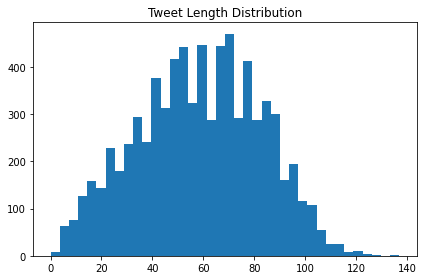

In [ ]:
lens = []
for tweet in train.text:
  lens.append(len(tweet))

plt.hist(lens, bins='auto')
plt.title('Tweet Length Distribution')
plt.tight_layout()
print('average tweet length: {}'.format(np.mean(lens)))

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# define Dataset class
class TorchDataset(Dataset):

  def __init__(self, tweets, tokenizer, max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_mask = []
    self.segment_ids = []
    self.target = tweets.target.to_numpy()

    for tweet in tweets.text:
      # tokenizing on a word level
      # encodings is dictionary with 3 keys:
      # one are the tokenized inputs, one are attention_masks (what to pay attention to), and one is to determine which sequence
      # all tweets are padded to length of 'max_length' w/ the pad token
      # padded tokens are defaulted w/ attention 0
      encodings = tokenizer(tweet, truncation=True, max_length=MAX_LEN, padding="max_length")
      self.input_ids.append(torch.tensor(encodings['input_ids']))
      self.attn_mask.append(torch.tensor(encodings['attention_mask']))
      self.segment_ids.append(torch.tensor(encodings['token_type_ids']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return {'input_ids': self.input_ids[idx], 'attn_mask': self.attn_mask[idx], 'segment_ids': self.segment_ids[idx], 'labels': self.target[idx]}

In [ ]:
MAX_LEN = 140
dataset = TorchDataset(train, tokenizer, MAX_LEN)
tokenizer.decode((list(dataset))[0]['input_ids'])

'[CLS] deed reason earthquake may allah forgive u [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
TRAIN_SIZE = int(0.85 * len(dataset))
VAL_SIZE = len(dataset) - TRAIN_SIZE

train_ds, val_ds = random_split(dataset, [TRAIN_SIZE, VAL_SIZE])

In [ ]:
# DataLoader similar to tfdatset, shuffle and batch 
# train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) 
# for train, shuffle and batch randomly
BATCH_SIZE = 8
train_dataloader = DataLoader(train_ds, 
                              sampler = RandomSampler(train_ds), 
                              batch_size = BATCH_SIZE)

# for validation can just batch sequentially.
val_dataloader = DataLoader(val_ds,
            sampler = SequentialSampler(val_ds),
            batch_size = BATCH_SIZE)

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.bert = bert_model
    self.drop = nn.Dropout(p=0.5)
    # dense layer
    self.out = nn.Linear(self.bert.config.hidden_size, 2)

  def forward(self, input_ids, attention_mask):
    hidden_state, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = Classifier()
device = torch.device("cuda")
model.cuda()

Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_dataloader) * epochs
# slowly tune with warm-up steps (use a low learning rate)
# then transition to initialized lr after the 100 steps are over
warmup_steps = 100

# change learning rate as throughout training loop
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer):
  num_correct = 0
  losses = []
  for d in dataloader:
    input_ids = d['input_ids'].to(device)
    attn_mask = d['attn_mask'].to(device)
    targets = d['labels'].to(device)
    outputs = model(input_ids=input_ids, attention_mask = attn_mask)
    # max logit for pred
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    num_correct += torch.sum(preds==targets)
    losses.append(loss.item())

    loss.backward()
    # clip gradient to avoid exploding gradient 
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    # reset gradients after each batch
    # same as model.zero_grad since optimizer utilizing model params
    optimizer.zero_grad()

  return num_correct.double() / len(train_ds), np.mean(losses)

In [ ]:
def eval_epoch(model, dataloader, loss_fn):
  num_correct = 0
  losses = []
  model = model.eval()
  for d in dataloader:
    input_ids = d['input_ids'].to(device)
    attn_mask = d['attn_mask'].to(device)
    targets = d['labels'].to(device)

    with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask = attn_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      num_correct += torch.sum(preds==targets)
      losses.append(loss.item())
      
  return num_correct.double() / len(val_ds), np.mean(losses)

In [ ]:
#train loop
from collections import defaultdict

history = defaultdict(list)
best_acc = 0

for epoch in range(1, epochs+1):
  print(f'Epoch {epoch}/{epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer)
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_epoch(model, val_dataloader, loss_fn)
  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_acc:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_acc = val_acc


Epoch 1/3
----------
Train loss 0.49412648641355844 accuracy 0.7729871735435019
Val loss 0.40937205476985944 accuracy 0.830122591943958

Epoch 2/3
----------
Train loss 0.3465709908783657 accuracy 0.8763715036315871
Val loss 0.46584679131637086 accuracy 0.8327495621716288

Epoch 3/3
----------
Train loss 0.2279317324079702 accuracy 0.9307680420336888
Val loss 0.6238094843350924 accuracy 0.8309982486865148



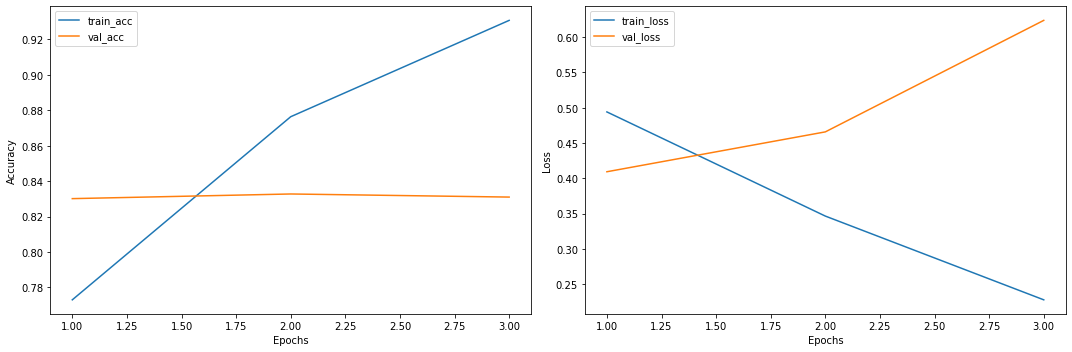

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(range(1, epochs+1), history['train_acc'], label='train_acc')
ax[0].plot(range(1, epochs+1), history['val_acc'], label='val_acc')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(range(1, epochs+1), history['train_loss'], label='train_loss')
ax[1].plot(range(1, epochs+1), history['val_loss'], label='val_loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.tight_layout()

In [ ]:
# define Dataset class
class TestDataset(Dataset):

  def __init__(self, tweets, tokenizer, max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_mask = []
    self.segment_ids = []

    for tweet in tweets.text:
      # tokenizing on a word level
      # encodings is dictionary with 3 keys:
      # one are the tokenized inputs, one are attention_masks (what to pay attention to), and one is to determine which sequence
      # all tweets are padded to length of 'max_length' w/ the pad token
      # padded tokens are defaulted w/ attention 0
      encodings = tokenizer(tweet, truncation=True, max_length=MAX_LEN, padding="max_length")
      self.input_ids.append(torch.tensor(encodings['input_ids']))
      self.attn_mask.append(torch.tensor(encodings['attention_mask']))
      self.segment_ids.append(torch.tensor(encodings['token_type_ids']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return {'input_ids': self.input_ids[idx], 'attn_mask': self.attn_mask[idx], 'segment_ids': self.segment_ids[idx]}

In [ ]:
test_dataset = TestDataset(test, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = BATCH_SIZE)


In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))

predictions = []
for d in test_dataloader:
  input_ids = d['input_ids'].to(device)
  attn_mask = d['attn_mask'].to(device)
  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask = attn_mask)
    _, preds = torch.max(outputs, dim=1)
    predictions.append(preds)

In [ ]:
flat_predictions = [item.tolist() for sublist in predictions for item in sublist]

In [ ]:
test['target']= flat_predictions

In [ ]:
from google.colab import files
test_export = test.loc[:, ['id', 'target']]
test_export.to_csv('bert_1.csv', index=False) 
files.download('bert_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>